# T-Bone Steak Simulation Results for NSF-DMS-2018 Proposal 


## Libraries

 * We make use of `numpy` to handle the sample sets defined as arrays, and we also use the `random` subpackage within `numpy` to generate random samples of various distributions.
 
 
 * We use a standard kernel densitmator in `scipy.stats` to approximate the densities on sample sets.
 
 
 * We use `matplotlib.pyplot` to visualize results.
 
 
 * We use `scipy.io` to load a data set. The `scipy.io` can read/write many data formats and is an overall useful way to connect Python scripts to computational codes written in almost any language. Read more about `scip.io` here https://docs.scipy.org/doc/scipy/reference/io.html.

In [2]:
# The libraries we will use
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import transforms
from scipy.stats import chi2, gaussian_kde as GKDE
from scipy.stats import norm, uniform, beta
from scipy.stats import multivariate_normal as mvnorm
import scipy.io as sio
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

## Stochastic to deterministic map figure

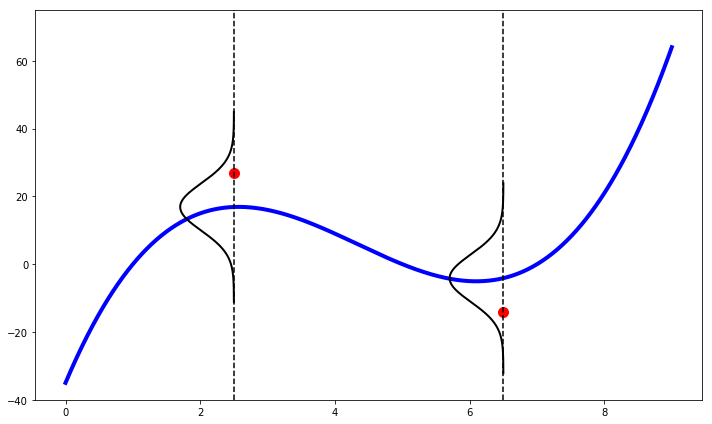

In [4]:
lam_regular = np.linspace(0,9,1000)

def Q(lam):
    return (lam-1)*(lam-5)*(lam-7)

Q_regular = Q(lam_regular)

fig = plt.figure(figsize=(10,6))

plt.clf()
plt.ylim([-40, 75])
plt.plot(lam_regular,Q_regular,'b-',linewidth=4)
ax = plt.gca()

def Q_distr(q,sigma):
    return norm(loc=q, scale=sigma)

lam_points = np.array([2.5, 6.5])
sigma = 1

Q_distrs = Q_distr(0,sigma)
y = np.linspace(-4*sigma,4*sigma, 1000)

x_pt = []
y_pt = []
Q_offsets = [10, -10]
for i in range(lam_points.size):
    rot = transforms.Affine2D().rotate_deg(90).scale(2, 7).translate(lam_points[i],Q(lam_points[i]))
    base = plt.gca().transData
    trans_data = rot + base
    plt.plot(y,Q_distrs.pdf(y), 'k-',linewidth=2,transform = trans_data)
    plt.plot([lam_points[i],lam_points[i]],ax.get_ylim(),'k--')
    x_pt.append(lam_points[i])
    y_pt.append(Q(lam_points[i])+Q_offsets[i])
    plt.scatter(x_pt[i],y_pt[i],100,'r')
#     s = '$\widehat{Q}(\lambda_' + str(i+1) + ',\xi)$'
#     offset = 0.1
#     plt.text(x_pt[i]+offset, y_pt[i]-20*offset, s, fontsize=20)
    
plt.tight_layout()
plt.savefig('stoch-map-illustration.pdf')
plt.show()

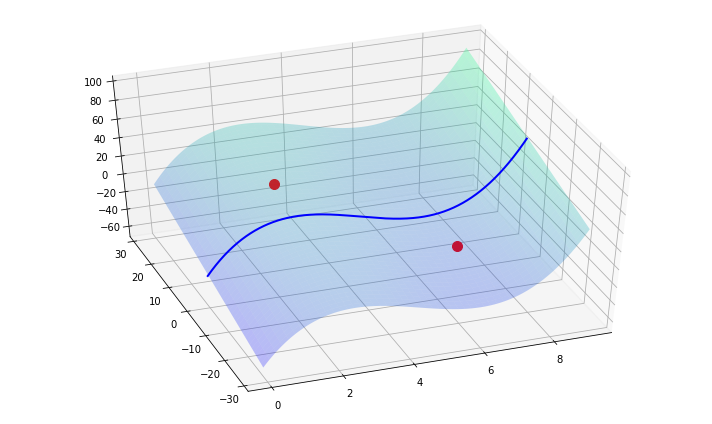

In [5]:
lam_grid = np.linspace(0,9,100)

xi_grid = np.linspace(-4*7*sigma,4*7*sigma,100)

lam_grid, xi_grid = np.meshgrid(lam_grid,xi_grid)

def Q_tilde(lam,xi):
    return (lam-1)*(lam-5)*(lam-7)+2 + xi

Q_plot = Q_tilde(lam_grid.reshape((100**2,1)),xi_grid.reshape((100**2,1)))


fig = plt.figure(figsize=(10,6))
fig.tight_layout()
ax = fig.gca(projection='3d')

ax.plot_surface(lam_grid, xi_grid, Q_plot.reshape((100,100)), cmap=cm.winter,
                      linewidth=1, antialiased=True, alpha=0.25)
ax.view_init(elev=45, azim=-110)
original_curve = ax.plot(lam_regular,0*lam_regular, Q_regular, linewidth=2, linestyle="-", c='b')

for i in range(lam_points.size):
    ax.scatter(lam_points[i],Q_offsets[i],y_pt[i],s=100,c='r')

plt.tight_layout()
plt.savefig('deterministic-map-illustration.pdf')
plt.show()

In [6]:
import seaborn as sn

/home/troy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/troy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


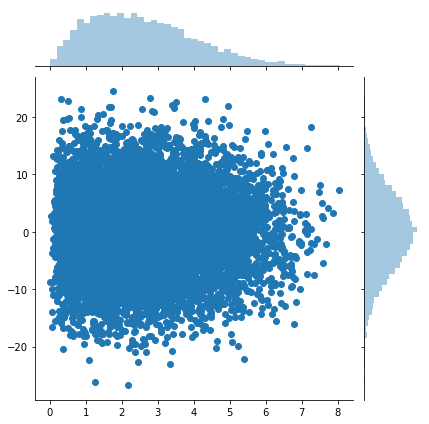

In [7]:
n_samples = int(1E4)
xi_samples = 7*Q_distrs.rvs(n_samples)
beta_distr = beta(2, 5, 0, 9) 
lam_samples = beta_distr.rvs(n_samples)

g = sn.jointplot(lam_samples,xi_samples)# kind='kde', space=0, color='b', bw=0.75)

g.ax_joint.legend_.remove()
plt.savefig('initial-sample-illustration.pdf')
jp_xlims = g.ax_joint.get_xlim()
jp_ylims = g.ax_joint.get_ylim()
plt.show()

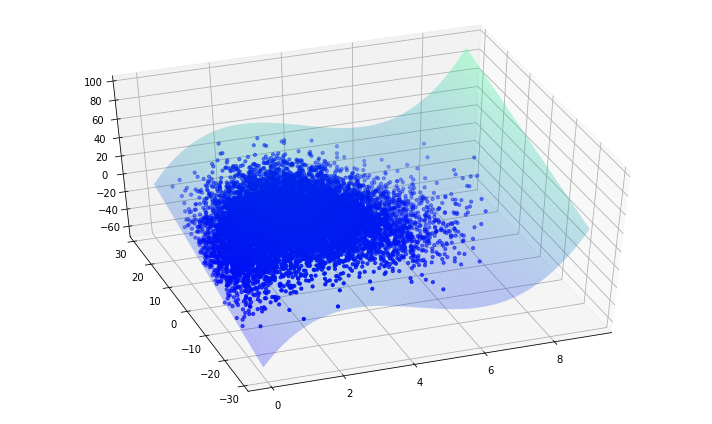

In [8]:
fig = plt.figure(figsize=(10,6))
fig.tight_layout()
ax = fig.gca(projection='3d')

ax.plot_surface(lam_grid, xi_grid, Q_plot.reshape((100,100)), cmap=cm.winter,
                      linewidth=1, antialiased=True, alpha=0.25)
ax.view_init(elev=45, azim=-110)

ax.scatter(lam_samples,xi_samples,Q_tilde(lam_samples,xi_samples),s=10,c='b')

plt.tight_layout()
plt.savefig('deterministic-map-init-samples-illustration.pdf')
plt.show()

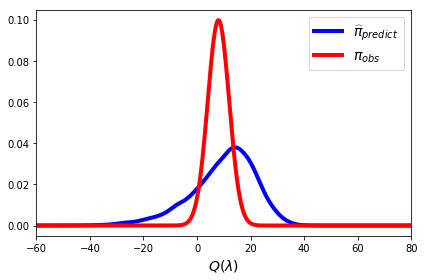

In [17]:
# Define an observed density
mu_q = 8
sigma_q = 4

qvals = Q_tilde(lam_samples,xi_samples)

qplot = np.linspace(-60,80,1000)

obs_q = norm.pdf(qplot, loc=mu_q, scale=sigma_q)
obs_vals = norm.pdf(qvals, loc=mu_q, scale=sigma_q)

plt.figure()

predict_kde = GKDE( qvals, 'silverman' )
predict_kde_plot = predict_kde(qplot)

obs_vals_plot = norm.pdf(qplot,  loc=mu_q, scale=sigma_q)

prplot = plt.plot(qplot,predict_kde_plot,'b-', linewidth=4, label="$\widehat\pi_{predict}$")
oplot = plt.plot(qplot,obs_vals_plot, 'r-', linewidth=4, label="$\pi_{obs}$")
plt.xlim([qplot.min(),qplot.max()])
plt.xlabel("$Q(\lambda)$", fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('det-map-observed-predicted.pdf')
plt.show()

In [ ]:
# plt.figure()
# plt.scatter(qvals[0,:],qvals[1,:])
# (eig_vals,_) = np.linalg.eig(np.cov(qvals))
# print(np.mean(qvals,axis=1))
# print(np.cov(qvals)/10)

## Now we perform rejection sampling (see previous lecture for a review)

Notice how ***fast*** this is because all the computations are taking place in a 1-dimensional data space.

In [11]:
def rejection_sampling(r):
    # Perform accept/reject sampling on a set of proposal samples using
    # the weights r associated with the set of samples and return
    # the indices idx of the proposal sample set that are accepted.
    N = r.size # size of proposal sample set
    check = np.random.uniform(low=0,high=1,size=N) # create random uniform weights to check r against
    M = np.max(r)
    print(M)
    new_r = r/M # normalize weights 
    idx = np.where(new_r>=check)[0] # rejection criterion
    return idx

In [18]:
# Compute the posterior
r = np.divide(obs_vals,predict_kde(qvals))
    
samples_to_keep = rejection_sampling(r)

post_q = qvals[samples_to_keep]
post_lam = lam_samples[samples_to_keep]
post_xi = xi_samples[samples_to_keep]

accept_rate = samples_to_keep.size/lam_samples.shape[0]
print(accept_rate)
print(np.mean(r))

3.3179234255082246
0.3043
1.0052436175882598


/home/troy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/troy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


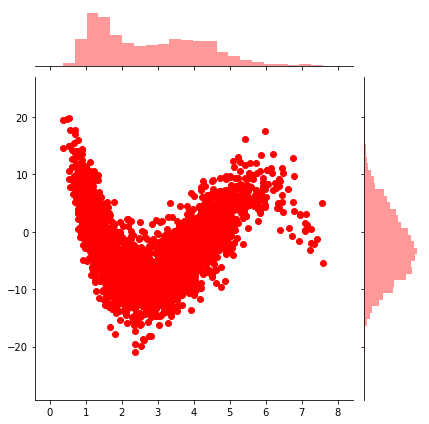

In [13]:
g = sn.jointplot(post_lam,post_xi, color='r')#, kind='kde', space=0, color='b', bw=0.75)

g.ax_joint.legend_.remove()

g.ax_joint.set_xlim(jp_xlims)
g.ax_joint.set_ylim(jp_ylims)

plt.savefig('updated-sample-illustration.pdf')

plt.show()

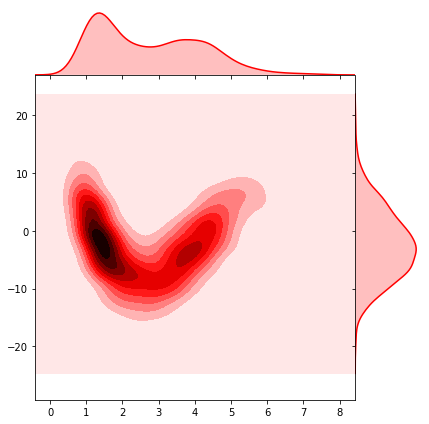

In [14]:
g = sn.jointplot(post_lam,post_xi, color='r', kind='kde', space=0)

g.ax_joint.legend_.remove()

g.ax_joint.set_xlim(jp_xlims)
g.ax_joint.set_ylim(jp_ylims)

plt.savefig('updated-density-illustration.pdf')

plt.show()

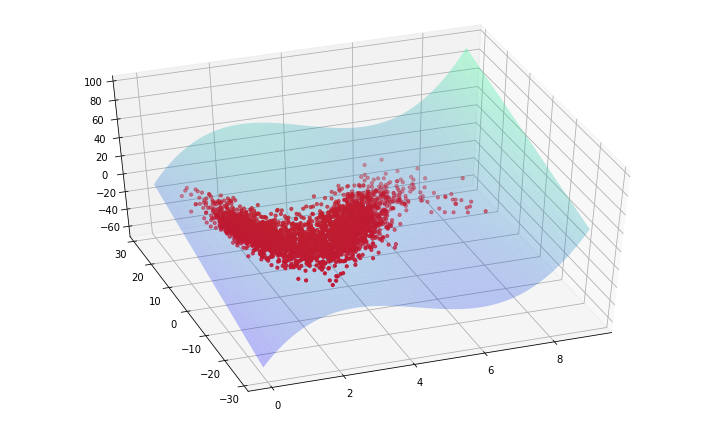

In [16]:
fig = plt.figure(figsize=(10,6))
fig.tight_layout()
ax = fig.gca(projection='3d')

ax.plot_surface(lam_grid, xi_grid, Q_plot.reshape((100,100)), cmap=cm.winter,
                      linewidth=1, antialiased=True, alpha=0.25)
ax.view_init(elev=45, azim=-110)

ax.scatter(post_lam,post_xi,Q_tilde(post_lam,post_xi),s=10,c='r')

plt.tight_layout()
plt.savefig('deterministic-map-update-samples-illustration.pdf')
plt.show()

## Don't forget to do some diagnostics

In [24]:
print(np.mean(post_q))
print(np.std(post_q))
print(np.mean(r))
print(np.mean(r*np.log(r)))
print((7.977-8)/8*100)
print((4.047-4)/4*100)

7.977690393377313
4.047396158298312
1.0052436175882598
0.7194773726610525
-0.2874999999999961
1.1749999999999927


## Visualizing results

 * We almost always start by checking the push-forwards against the observed density.  
 
 
 * If the data space is higher-dimensional, we may only visualize the marginals of the densities, or we may instead opt to visualize certain statistics of the distribution or the marginals as we show below for the 100-dimensional parameter space.

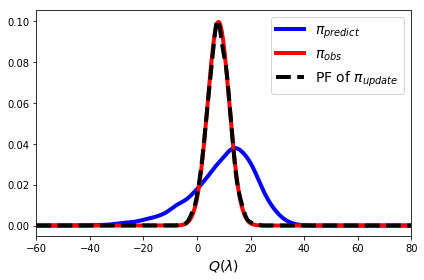

In [20]:
# Compare the observed and the pushforwards of prior and posterior
# Define an observed density
plt.figure()

predict_kde = GKDE( qvals, 'silverman' )
predict_kde_plot = predict_kde(qplot)

obs_vals_plot = norm.pdf(qplot,  loc=mu_q, scale=sigma_q)

postq_kde = GKDE( Q_tilde(post_lam,post_xi), 'silverman' )
postq_kde_plot = postq_kde(qplot)

prplot = plt.plot(qplot,predict_kde_plot,'b-', linewidth=4, label="$\pi_{predict}$")
oplot = plt.plot(qplot,obs_vals_plot, 'r-', linewidth=4, label="$\pi_{obs}$")
poplot = plt.plot(qplot,postq_kde_plot,'k--', linewidth=4, label="PF of $\pi_{update}$")
plt.xlim([qplot.min(),qplot.max()])
plt.xlabel("$Q(\lambda)$", fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('det-map-observed-predicted-updated.pdf')
plt.show()

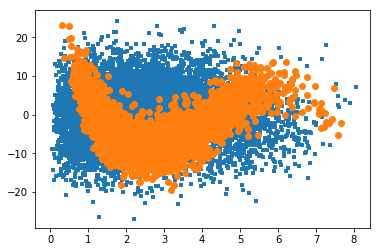

In [21]:
plt.figure()
plt.clf()
plt.scatter(lam_samples,xi_samples, 9, marker='s')
plt.scatter(post_lam,post_xi)

In [25]:
print(np.mean(post_xi))
print(np.std(post_xi))
print(np.mean(xi_samples))
print(np.std(xi_samples))

-2.3967031284145124
5.9883128183392635
0.0011917054018225712
6.863058340949535


In [ ]:
lam_1_plot = np.linspace(0.9, 1.6, 25)
lam_2_plot = np.linspace(0.18,0.32,25)
lam_1_plot, lam_2_plot = np.meshgrid(lam_1_plot,lam_2_plot)
post_lam_kde = GKDE( post_lam, 'silverman' )
post_lam_kde_vals = post_lam_kde(np.array([lam_1_plot.flatten(),lam_2_plot.flatten()]))

In [ ]:
fig = plt.figure(figsize=(10,6))
fig.tight_layout()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(lam_1_plot, lam_2_plot, 
                       0*lam_1_plot+1/((lam_1_plot.max()-lam_1_plot.min())*(lam_2_plot.max()-lam_2_plot.min())),
                    label='$\pi_{init}$',
                       color='b',
                      linewidth=0, antialiased=True)
surf = ax.plot_surface(lam_1_plot, lam_2_plot, post_lam_kde_vals.reshape(25,25), 
                       label='$pi_{update}$', color='r',
                       linewidth=0, antialiased=True, alpha=0.5)
fake2Dline_0 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline_1 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline_0, fake2Dline_1], 
          ['$\pi_{init}$', '$\pi_{update}$'], numpoints = 1, fontsize = 14,
         loc = 'center left', bbox_to_anchor=(0.25, 0.75))

plt.xlabel('Thermal Diffusivity of Protein', fontsize=12)
plt.ylabel('Thermal Diffusivity of Bone',fontsize=12)
plt.savefig('t-bone-update-init.pdf')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
fig.tight_layout()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(lam_1_plot, lam_2_plot, 
                       0*lam_1_plot+1/((lam_1_plot.max()-lam_1_plot.min())*(lam_2_plot.max()-lam_2_plot.min())),
                    label='$\pi_{init}$',
                       color='b',
                      linewidth=0, antialiased=True)

fake2Dline_0 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')

ax.legend([fake2Dline_0], 
          ['$\pi_{init}$'], numpoints = 1, fontsize = 14,
         loc = 'center left', bbox_to_anchor=(0.25, 0.75))

plt.xlabel('Thermal Diffusivity of Protein', fontsize=12)
plt.ylabel('Thermal Diffusivity of Bone',fontsize=12)
plt.savefig('t-bone-init.pdf')
plt.show()

In [ ]:
def QoI(lam,p): # defing a QoI mapping function
    q = lam**p
    return q

In [ ]:
N, mu, sigma = int(1E4), 0.25, 0.1 # number of samples from prior and observed mean (mu) and st. dev (sigma)
lam = np.random.uniform(low=-1,high=1,size=N) # sample set of the prior

# Evaluate the QoI map on this prior sample set
qvals_nonlinear = QoI(lam,5) # Evaluate lam^5 samples

# Estimate the push-forward density for the QoI
q_nonlinear_kde = GKDE( qvals_nonlinear )

In [ ]:
# Evaluate the observed density on the QoI sample set
obs_vals_nonlinear = norm.pdf(qvals_nonlinear, loc=mu, scale=sigma)

# Compute r
r_nonlinear = np.divide(obs_vals_nonlinear,1/10*np.abs(qvals_nonlinear)**(-4/5))

# Perform rejection sampling
samples_to_keep_nonlinear = rejection_sampling(r_nonlinear)
post_lam_nonlinear = lam[samples_to_keep_nonlinear]

# Construct push-forward of the pullback density
post_q_nonlinear = qvals_nonlinear[samples_to_keep_nonlinear] 
postq_nl_kde = GKDE( post_q_nonlinear ) 

In [ ]:
mu_plot = np.linspace(0.1,0.25,50)
lam_plot = np.linspace(-1,1,50)
mu_plot, lam_plot = np.meshgrid(mu_plot, lam_plot)
print(lam_plot[:,0])

In [ ]:
fig = plt.figure(figsize=(10,6))
fig.tight_layout()
ax = fig.gca(projection='3d')

update_plot = np.zeros((50,50))
for i in range(50):
    update_plot[i,:] = uniform.pdf(lam_plot[:,0], loc=-1, scale=2)*\
                         (lam_plot[:,0]-mu_plot[0,i])/sigma**2*\
                         norm.pdf(QoI(lam_plot[:,0],5), loc=mu_plot[0,i], scale=sigma)/\
                         (1/10*np.abs(QoI(lam_plot[:,0],5))**(-4/5))
    

# Plot the surface.
surf = ax.plot_surface(mu_plot, lam_plot, 
                       update_plot,
                      linewidth=0, antialiased=True)

fake2Dline_0 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')

plt.xlabel('$\mu$', fontsize=12)
plt.ylabel('$\lambda$',fontsize=12)
plt.show()